<a href="https://colab.research.google.com/github/EliTaub1/bio108_tutorial/blob/main/cephalopod_salinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Species Distributions and Climate

Among the most fundamental requirement for conserving a species is understand the environmental conditions necessary for it to survive. Species distributions are complex and influenced by a range of factors, both biotic and abiotic, which must be considered in understanding areas to protect and implementing management strategies (such as translocations, invasive species removal, etc.).

Here, we focus on the climatic conditions necessary for a species to survive. Species are constrained to be able to survive only within certain bounds of environmental variables, which is known as the Hutchinsonian (or fundamental) niche. Though biotic factors and other influences such as anthropogenic development may reduce the actual distribution of a species to a smaller range (the so-called "realized niche"), the Hutchinsonian niche is still valuable as a way to understand the potential for a species to survive within a certain region.

## Motivating Question: Cephalopod Distribution

Here, we examine the distribution of cephalopods in the Canary Current to see if different families of cephalopods have different ocean salinity preferences. Cephalopods, a class of molluscs which include squid and octopus, have a diverse range of habitats which they inhabit, making them a valuable taxon for understanding the environmental factors underlying their distributions. Considering the diversity of cephalopod life history patterns, it's important to undersand how different families of cephalopods are disribution and what role envrionmental variables have in determining their differing distributions. Thus, we are asking how different families of cephalopod are distributed in the Canary Current and which environmental variables may be behind this distribution.

We are using data from Luna et al (2025), which analyzed bathymetric preferences of 90 cephalopod species collected from bottom trawl surveys off the northwest coast of Africa between 2004 and 2012 (https://datadryad.org/dataset/doi:10.5061/dryad.15dv41p6j). Luna et al specifically sampled some oceanographic variables where they collected these bottom trawls, but since only depth was made public, we will use a more comprehensive set of oceanographic variables from Bio-ORACLE, a publicly avaiable dataset on worldwide oceanographic variables.

## Importing and installing packages
First, we install and import necessary packages that we will use in this analysis.

In [1]:
#install packages
! pip install rasterio rioxarray rasterstats pyo_oracle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.3 MB/s eta 0:00:00


In [19]:
#import packages
from google.colab import drive #allows access to data files in Google Drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.plot
from shapely.geometry import Point
import rasterstats
import os
import pyo_oracle
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Data
### Cephalopod Distribution
The data from Luna et al were saved as a Excel (.xlsx) file. For the purposes of this tutorial, they have already been covnerted to a .csv and uploaded to Google Drive.

We start by importing the data as a csv before turning the Longitude and Latitude values into spatial points that can be read as a GeoDataFrame.

In [3]:
#Import cephalopod data
cephalopod_path = "/content/drive/MyDrive/Colab Notebooks/Supporting_data_-_Cephalopods_distribution_paper.csv" #path within google drive, modify as needed
cephalopod = pd.read_csv(cephalopod_path)

#create GPD with cephalopod locations as spatial points
cephalopod_coords = cephalopod[["Long L", "Latit L"]]
cephalopod_coords = cephalopod_coords.to_numpy()
cephalopod_locations = [Point(xy) for xy in cephalopod_coords] #converts coordinate array into spatial points

cephalopod_locations = gpd.GeoDataFrame(cephalopod_locations,
                                  columns=['geometry'],
                                  crs="epsg:4326")
#add family data for each data point
cephalopod_locations["Family"] = cephalopod["Family"]
cephalopod_locations["Species"] = cephalopod["Species"]

#remove NA locations
cephalopod_locations = cephalopod_locations.loc[(cephalopod_locations.is_empty) == False]

### Envrionmental Variables
Now, we add in our oceanographic data from Bio-ORACLE (https://bio-oracle.org/index.php). Bio-ORACLE has an associated package, pyo_oracle, which makes it easy to acquire Bio-ORACLE datasets and download them directly into our directory!

First, we filter layers to get only the ones we desire and then we download these layers in the temporal and geographical range used in the reference study.

In [4]:
# Get full list of layers available
bio_oracle_layers = pyo_oracle.list_layers()

#reset pyo_oracle data from previous uses and then recreate folder
os.system('rm -rf /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')
os.system('mkdir /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')

#Select only layers of variables taken during the baseline period (2000-2018/2019/2020)
baselineLayers = bio_oracle_layers[bio_oracle_layers["datasetID"].str.contains("baseline")]
#Select only layers of variables taken at the benthic layer (as this is where the bottom trawls were conducted)
usedLayers = baselineLayers[baselineLayers["datasetID"].str.contains("depthmean")]

# Define constraints on layers to be in desired temporal range and latitude/longitude range. Here, we use the constraints of our reference study.y
constraints = {
    "time>=": "2004-01-01T00:00:00Z",
    "time<=": "2012-01-01T12:00:00Z",
    "time_step": 1,
    "latitude>=": 8,
    "latitude<=": 36,
    "latitude_step": 1,
    "longitude>=": -20,
    "longitude<=": 11,
    "longitude_step": 1
}

#Download layers using the IDs remaining after we've filtered
for title in usedLayers.datasetID:
  pyo_oracle.download_layers(title, constraints=constraints, skip_confirmation = True)

Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/chl_baseline_2000_2018_depthmean_2025-04-01-043454.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/dfe_baseline_2000_2018_depthmean_2025-04-01-043500.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/

In [5]:
#Reference: https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff
import xarray as xr
import rioxarray as rio

#Create save location for files
save_folder = '/content/oceandata/'
os.system(('mkdir /content/oceandata/'))

#List all files in the directory with .nc suffix
pyo_directory = "/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/"
nc_filenames = os.listdir(pyo_directory)
nc_filenames = [s for s in nc_filenames if ".nc" in s]

#Rewrite nc as a .tif as save
for filename in nc_filenames:
  #open file with name suffix
  variable_path = pyo_directory + filename
  variable = xr.open_dataset(variable_path)
  #only extract the data variable with "mean" in the name
  var_name = [s for s in variable._variables if "mean" in s]
  var_data = variable[var_name[0]]
  #convert var_data into a format where it can be saved as .tif
  var_data = var_data.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
  var_data = var_data.rio.write_crs("epsg:4326", inplace=True)
  #save var_data
  save_loc = save_folder + var_name[0] + ".tif"
  var_data.rio.to_raster(save_loc)

### Combining Data Sources

Now, we extract envriomental data for each of the datapoints and add it back to the cephalopod location GeoDataFrame.

In [6]:
tif_filenames = os.listdir(save_folder)

for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))

  #extract envrionmental variable data
  variable_results = rasterstats.point_query(
      cephalopod_locations,
      variable_raster.read(1),
      nodata = variable_raster.nodata,
      affine = variable_raster.transform,
      interpolate='nearest'
  )
  #add envrionmental variable data back to cephalopod data
  cephalopod_locations[filename.replace(".tif",'')] = variable_results

#remove NA values
cephalopod_locations = cephalopod_locations.dropna()

### Analysis #1: Salinity
To start with, we will take a look at how cephalopods differ in one of the variables we are testing: salinity.

We start by isolating salinity data, grouping our data by family and calculating salinity summary stastics for each family of cephalopod.

In [ ]:
#calculate salinity summary statistics by order
mean_salinity_order = cephalopod_locations.groupby(["Family"])["so_mean"].describe()

#find minimum and maximum salinity values of cephalopods
min_sal = cephalopod_locations["so_mean"].min()
max_sal = cephalopod_locations["so_mean"].max()

Lastly, we plot our data. Note that our y axis is set to the range of salinity values at which cephalopods are found, as this gives a better idea of the range of values that may exist than starting at 0.

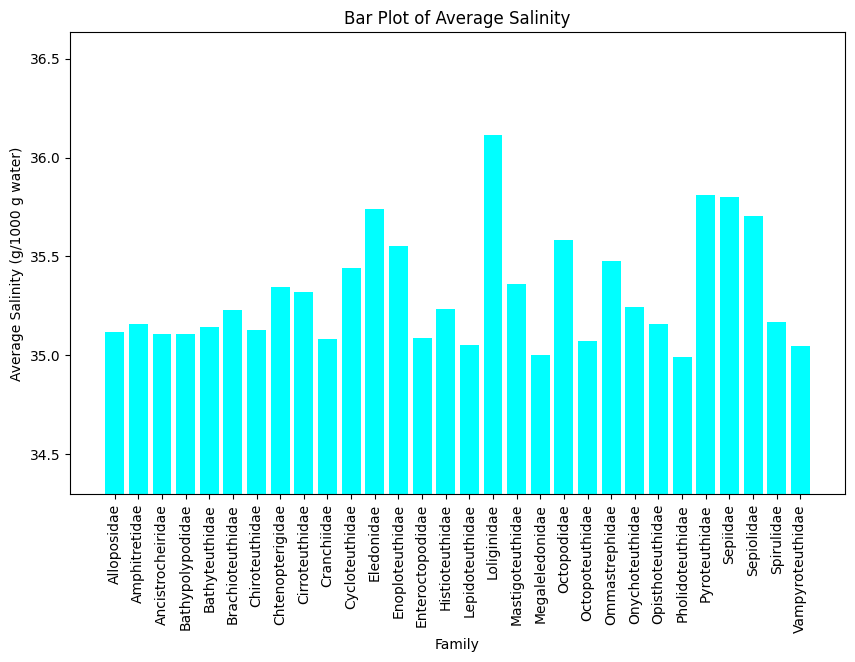

In [ ]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.bar(mean_salinity_order.index,
       mean_salinity_order["mean"], #uses mean salinity for each order
       color = 'cyan')

#change y axis bounds to minimum and maximum observed salinity
ax.set_ylim([min_sal, max_sal])

#rotate axis ticks in order to make family names visible
plt.xticks(rotation=90)

# Set plot title and axes labels
ax.set(title = "Bar Plot of Average Salinity",
       xlabel = "Family",
       ylabel = "Average Salinity (g/1000 g water)");

#save and plot figure
plt.savefig("cephalopod_salinity.png")
plt.show()

Here, we can see that within the Canary Current, cephalopod families have some variability in the mean salinity values of captured individuals (though we have not tested the statistical significance of these differences).

This indicates that salinity may have a role in determining the niches occupied by different cephalopod families. However, it is unclear if this is a causal relationship (i.e. there is also a chance that some variable which correlates with salinity is determining these differences). Also, considering the relatively narrow range of salinity values in the Canary Current to begin with, there is some doubt as to how much these small differences in salinity could limit these families' distributions.

###Analysis #2: Principal Component Analysis

Now, let's take a look at how different families of cephalopod have distributions that differ by climate. There's only one problem: we're working with 12 different environmental variables! How can we visualize variation along so many different variables.

This is where Principal Component Analysis comes in. By using PCA, it's possible to reduce the dimensionality of our data, bringing it down from 12 dimensions to only 2 dimensions that use combinations of our variables to capture a large proportion of the variance of our dataset.

Here, we use SciKitLearn's PCA tool to conduct this analysis.

In [ ]:
#Create dataframe with only environmental variables
cephalopod_environment = cephalopod_locations.drop(['geometry', 'Family', 'Species'], axis = 1)

#Create model in SciKitLearn
model = PCA(n_components=2)
#Fit model to data
model.fit(cephalopod_environment)
#Determine principal components for our data
cephalopod_2D = model.transform(cephalopod_environment)

Now, we plot the various families of cephalopods based on environmental data. To make the visualization easier, we'll use only data from the most abundant families (>200 observations).

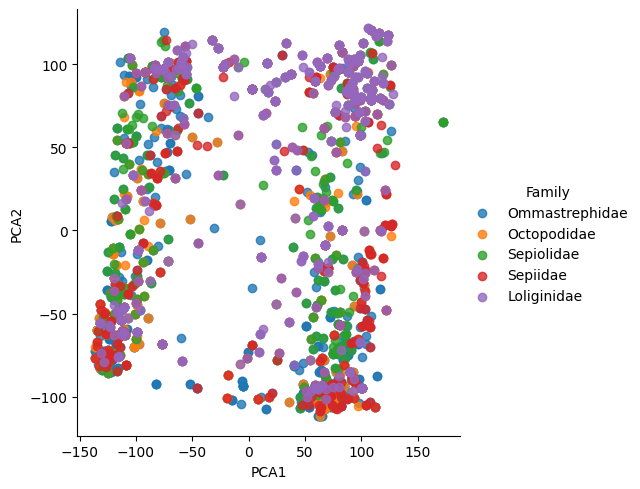

In [ ]:
#add cephalopod PCA back to original data
cephalopod_locations['PCA1'] = cephalopod_2D[:, 0]
cephalopod_locations['PCA2'] = cephalopod_2D[:, 1]

family_counts = cephalopod_locations.Family.value_counts()
family_counts = family_counts[family_counts > 200]

abund_locations = cephalopod_locations[cephalopod_locations["Family"].isin(family_counts.index)]

sns.lmplot(x="PCA1", y="PCA2", hue='Family', data=abund_locations, fit_reg=False)

This is pretty chaotic! We can see that the majority of individuals seem to fit into two major clusters for PC1, with some having values between -150 and -75 and others having values between 50 and 120. PC2, however, looks a lot more spread out. From this plot, it's readily apparently that different families of cephalopod have highly overlapping environmental ranges, with all families being distributed across the plot.

The high abundance families are thus all able to occupy the range of suitable cephalopod habitats of the Canary Current, showing that environmental constaints are not limiting their distribution provided the habitat has some degree of suitability for cephalopods.

###Analysis 3: Species Distribution Modeling

What if we want to look at a particular species and determine its likelihood of being found in a given location in the Canary Current? This seems like an immensely complex task, since we sampled only a small range of points in the region and need to make a prediction for any point within the area.

Luckily, this is where machine learning can be quite valuable! Here, we construct a basic model to predict the distribution of the squid *Todaropsis eblanae*.

First, we create a list of points where the species both was and was not found.

In [86]:
#Create locations where study species was found
tod_ebl_locations = cephalopod_locations[cephalopod_locations["Species"] == "Todaropsis eblanae"]
tod_ebl_locations = tod_ebl_locations.drop_duplicates(subset = "geometry") #remove duplicate locations
tod_ebl_locations["tod_ebl"] = "TRUE"

#Create locations where study species was not found
other_locations = cephalopod_locations[~ cephalopod_locations["geometry"].isin(tod_ebl_locations.geometry)]
other_locations = other_locations.drop_duplicates(subset = "geometry") #remove duplicate locations
other_locations["tod_ebl"] = "FALSE"

#Combine dataframes into single entry
frame_concat = [tod_ebl_locations, other_locations]
location_frame = pd.concat(frame_concat)

#Create training and test data
location_data = location_frame.drop(["geometry", "Family", "Species","tod_ebl"], axis = 1)
location_target = location_frame.tod_ebl
traindata, testdata, traintarget, testtarget = train_test_split(location_data, location_target, random_state = 47)

#Feed data into RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(traindata, traintarget)

#Generate and test predictions
pred = model.predict(testdata)
predaccuracy = [pred == testtarget]

Now that we've created this model, we can evaluate all data within the given dataframe.

In [102]:
###WORK IN PROGRESS: NEED TO SEE HOW TO CONVERT BACK TO A VERSION WHICH CAN BE PLOTTED AND THUS VISUALIZED
###ALSO, WOULD BE BETTER TO QUANTIFY PERCENT LIKELYHOOD OF TRUE OR FALSE IF POSSIBLE, UNSURE HOW TO DO THAT

tif_filenames = os.listdir(save_folder)

holderArray = np.zeros((12, 561, 621))
i = 0

for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))
  holderArray[[i]] = variable_raster.read(1)
  i = i + 1

newHolder = pd.DataFrame(holderArray.reshape(12, 348381).transpose(1,0))

holderpred = model.predict(testdata)
